In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [7]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/dataset.zip'

# Directory to extract files
extract_to_dir = '/content/dataset'

# Unzip the file
!unzip -q {zip_file_path} -d {extract_to_dir}

print('Unzipping complete!')


Unzipping complete!


In [8]:
IMG_SIZE = 224  # Ukuran gambar yang diperlukan oleh MobileNetV2
BATCH_SIZE = 32
DATASET_PATH = 'dataset'  # Path ke folder dataset Anda


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    validation_split=0.2,  # misal membagi dataset untuk training dan validation
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 1483 images belonging to 9 classes.
Found 365 images belonging to 9 classes.


In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Membekukan layer base model
for layer in base_model.layers:
    layer.trainable = False

# Menambahkan layer baru di atas base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Tambahkan dropout dengan rate 0.5
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Tambahkan dropout dengan rate 0.5
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 [==============================] - 0s 0us/step


In [12]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [14]:

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

# Training model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,  # Menambah jumlah epoch untuk melihat apakah performa meningkat
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/30
47/47 [==============================] - 115s 2s/step - loss: 1.7457 - accuracy: 0.5361 - val_loss: 0.9677 - val_accuracy: 0.6932 - lr: 0.0010
Epoch 2/30
47/47 [==============================] - 102s 2s/step - loss: 1.1174 - accuracy: 0.6797 - val_loss: 0.7802 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 3/30
47/47 [==============================] - 101s 2s/step - loss: 0.9460 - accuracy: 0.7175 - val_loss: 0.7705 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 4/30
47/47 [==============================] - 100s 2s/step - loss: 0.8521 - accuracy: 0.7519 - val_loss: 0.7172 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 5/30
47/47 [==============================] - 101s 2s/step - loss: 0.8483 - accuracy: 0.7492 - val_loss: 0.5830 - val_accuracy: 0.8329 - lr: 0.0010
Epoch 6/30
47/47 [==============================] - 100s 2s/step - loss: 0.8011 - accuracy: 0.7559 - val_loss: 0.5830 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 7/30
47/47 [==============================] - 112s 2s/step - loss: 0.7

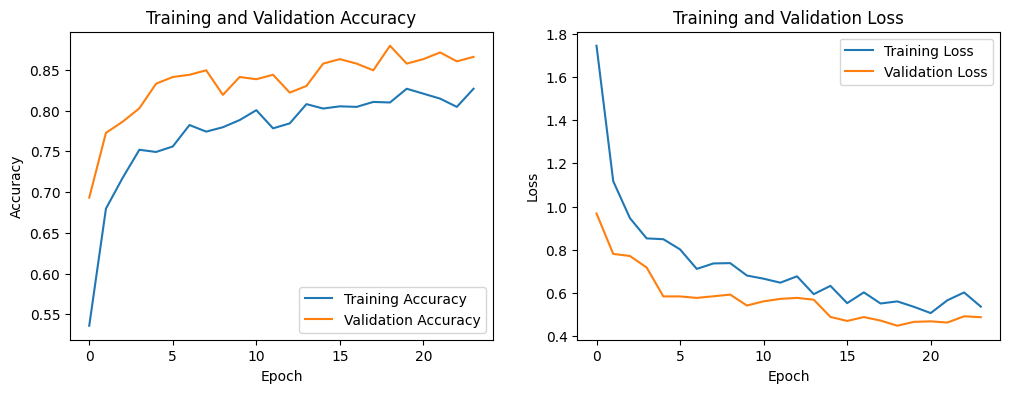

In [15]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [16]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
import tensorflow as tf
from tflite_support.metadata import metadata_schema_py_generated as _metadata_fb
from tflite_support.metadata import writer_utils
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils
import flatbuffers

# Path to the SavedModel directory
saved_model_dir = "C:/Users/Acer/AppData/Local/Temp/tmpzbkyiqks/mobilenet/2"

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = 'newest_model/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Define the metadata
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "MobileNetV2 Food Image Classifier"
model_meta.description = ("Model to classify images of 9 types of food.")
model_meta.version = "v1.0"
model_meta.author = "Damar Satria Buana"
model_meta.license = ("Apache License. Version 2.0 https://www.apache.org/licenses/LICENSE-2.0.")

# Create input metadata
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "image"
input_meta.description = ("Input image of food to be classified.")
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = _metadata_fb.ColorSpaceType.RGB
input_meta.content.contentProperties.type = _metadata_fb.ImageType.IMAGE
input_meta.contentStats = _metadata_fb.StatsT()
input_meta.contentStats.max = [255.0]
input_meta.contentStats.min = [0.0]
input_meta.processUnits = [_metadata_fb.ProcessUnitT()]
input_meta.processUnits[0].optionsType = _metadata_fb.ProcessUnitOptions.ImagePreprocessingOptions
input_meta.processUnits[0].options = _metadata_fb.ImagePreprocessingOptionsT()
input_meta.processUnits[0].options.normalizationOptions = _metadata_fb.NormalizationOptionsT()
input_meta.processUnits[0].options.normalizationOptions.mean = [127.5]
input_meta.processUnits[0].options.normalizationOptions.std = [127.5]

# Create output metadata
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = ("Probabilities of the 9 food classes.")
output_meta.content = _metadata_fb.ContentT()
output_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
output_meta.contentStats = _metadata_fb.StatsT()
output_meta.contentStats.max = [1.0]
output_meta.contentStats.min = [0.0]

# Add input and output metadata to the model
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]

model_meta.subgraphMetadata = [subgraph]

# Serialize the metadata and add it to the model
b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata_fb.ModelMetadataT.GetRootAsModelMetadata(b),
)

metadata_buf = b.Output()
populator = writer_utils.MetadataPopulator.with_model_file(tflite_model_path)
populator.load_metadata_buffer(metadata_buf)
populator.populate()

# Save the model with metadata
with open('model_with_metadata.tflite', 'wb') as f:
    f.write(populator.get_tflite_model_with_metadata())
